In [1]:
import numpy as np
import torch
from torch import optim
import os
import sys
sys.path.append('C:\\Users\\chris\\Desktop\\Masterarbeit\\code')
from utils.dataloader import get_data_loader
from networks.cnn import CNN, CNN_pool
import matplotlib.pyplot as plt
import pyreadr

In [2]:
# Dataloader
dataloader, dataset = get_data_loader(data_path = "../data/exp_1/data/", batch_size=800, train = False)

In [3]:
#Load model
net = CNN()
net.load_state_dict(torch.load("../data/exp_1/checkpoints/cnn.pt"))
net.eval()

CNN(
  (conv_1): Conv2d(1, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv_3): Conv2d(128, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_1): Linear(in_features=256, out_features=4, bias=True)
  (linear_2): Linear(in_features=4, out_features=8, bias=True)
  (linear_3): Linear(in_features=8, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=2, bias=True)
)

In [4]:
for sample in dataloader:
    img, param = sample
    break 
pred = net(img).detach().numpy()
param = param.detach().numpy()

# Calculate metrics

In [5]:
def retransform(params):
    result = np.zeros(shape = params.shape)
    result[:,0] = np.exp(params[:,0])
    result[:,1] = (2*np.exp(params[:,1]))/(1+np.exp(params[:,1]))
    return result    

In [6]:
pred_tf = retransform(pred)
param_tf = np.round(retransform(param),3)

In [7]:
rmse = np.sqrt(np.mean((np.power(pred_tf-param_tf,2)), axis = 0))
mae = np.mean(np.abs(pred_tf-param_tf), axis = 0)
bias = np.mean(pred_tf-param_tf, axis = 0)
print(f"RMSE: {np.round(rmse,2)}")
print(f"MAE: {np.round(mae,2)}")
print(f"Bias: {np.round(bias,2)}")

RMSE: [0.31 0.21]
MAE: [0.21 0.17]
Bias: [ 0.14 -0.05]


# Plot results

In [8]:
exp = "exp_1"
model = "brown"
plot_path = f'../data/{exp}/plots/'

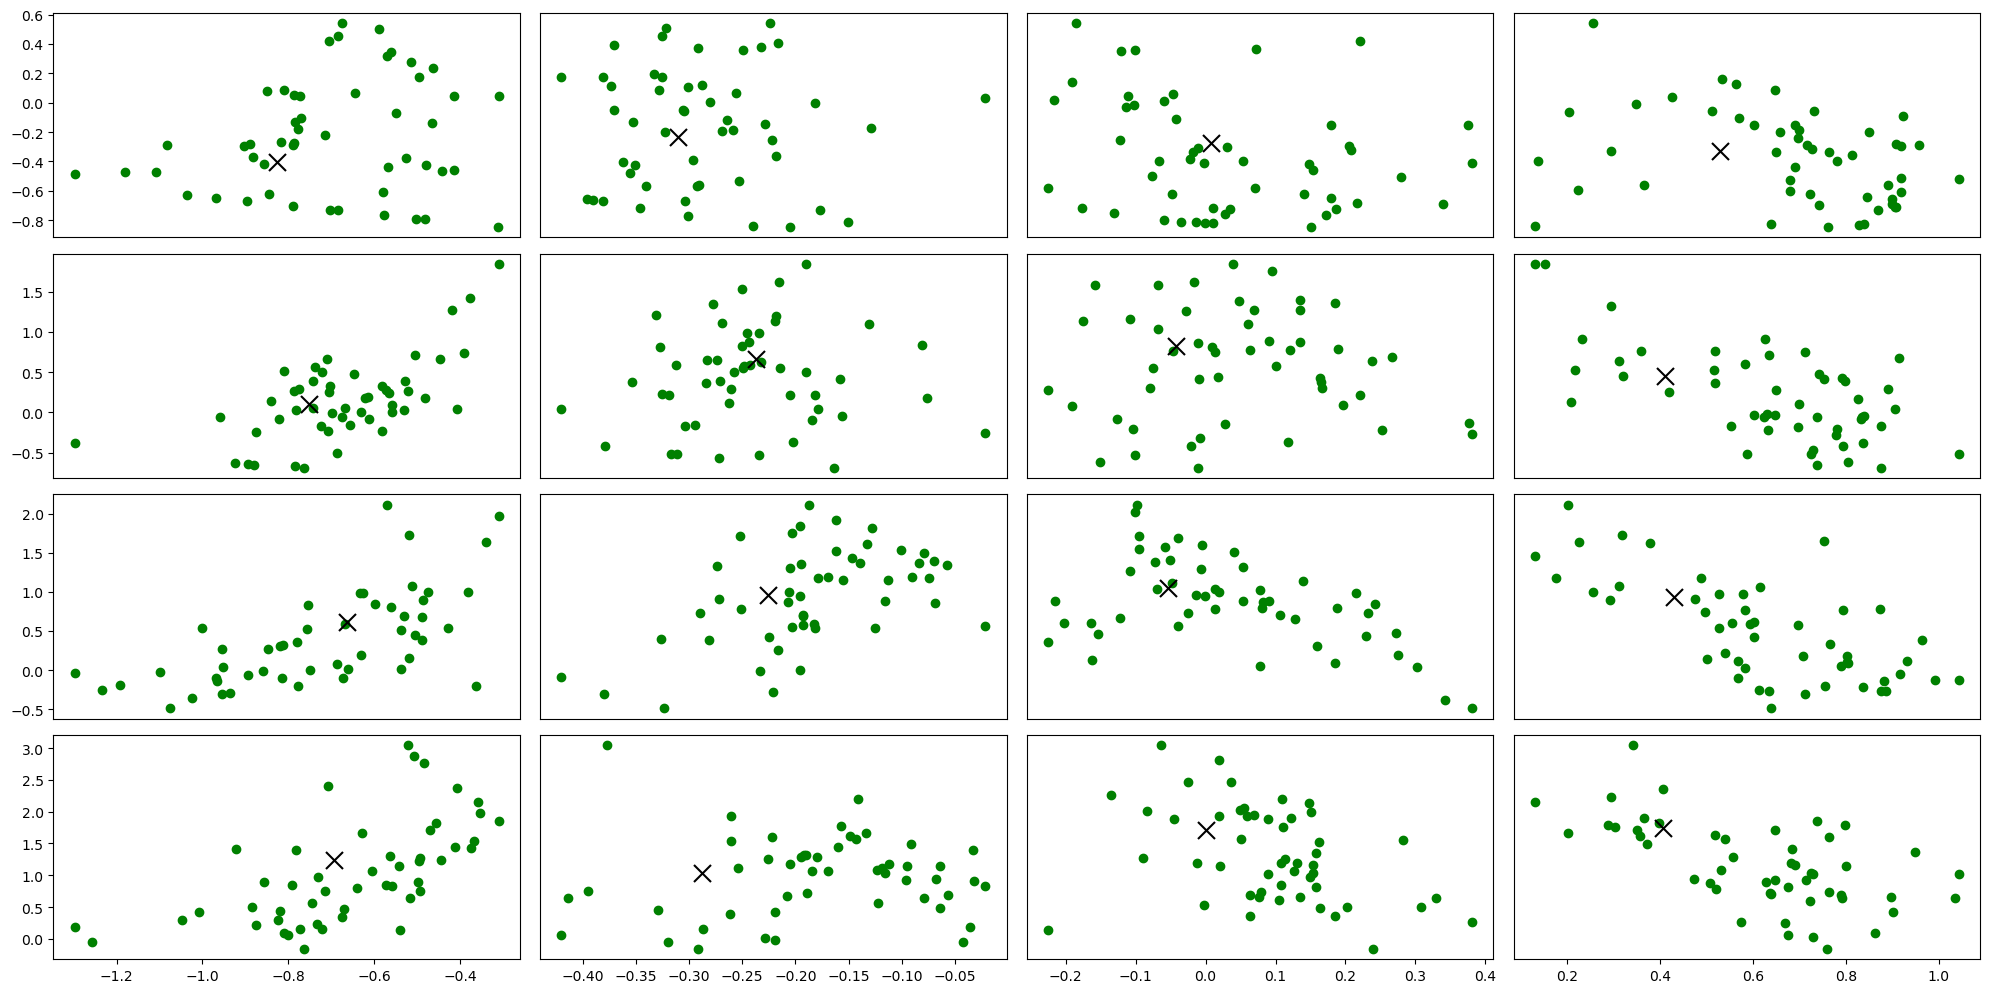

In [9]:
n_comb = 16
fig, axs = plt.subplots(4,4,figsize = (20,10))
axs = axs.ravel()
for i in range(n_comb):
    axs[i].scatter(x = pred[(i*50):((i+1)*50),0], y = pred[(i*50):((i+1)*50),1], color = "green")
    axs[i].scatter(x = param[5+(i*50),0], y = param[5+(i*50),1], color = "black", marker = "x", s = 150)
    if i < 12:
        axs[i].get_xaxis().set_visible(False)
    if (i%4) != 0:
        axs[i].get_yaxis().set_visible(False)  
        
fig.tight_layout()

plt.savefig(plot_path+"metrics_scatter_convergence.png", dpi = 300, bbox_inches = "tight")

# Results with Likelihood

In [10]:
ml_path = f'../data/{exp}/results/'
ml_data = pyreadr.read_r(ml_path+model+"_mle2.RData")["results"].to_numpy()

In [11]:
rmse = np.sqrt(np.mean((np.power(ml_data-param_tf,2)), axis = 0))
mae = np.mean(np.abs(ml_data-param_tf), axis = 0)
bias = np.mean(ml_data-param_tf, axis = 0)
print(f"RMSE: {np.round(rmse,2)}")
print(f"MAE: {np.round(mae,2)}")
print(f"Bias: {np.round(bias,2)}")

RMSE: [0.53 0.2 ]
MAE: [0.43 0.16]
Bias: [0.42 0.01]


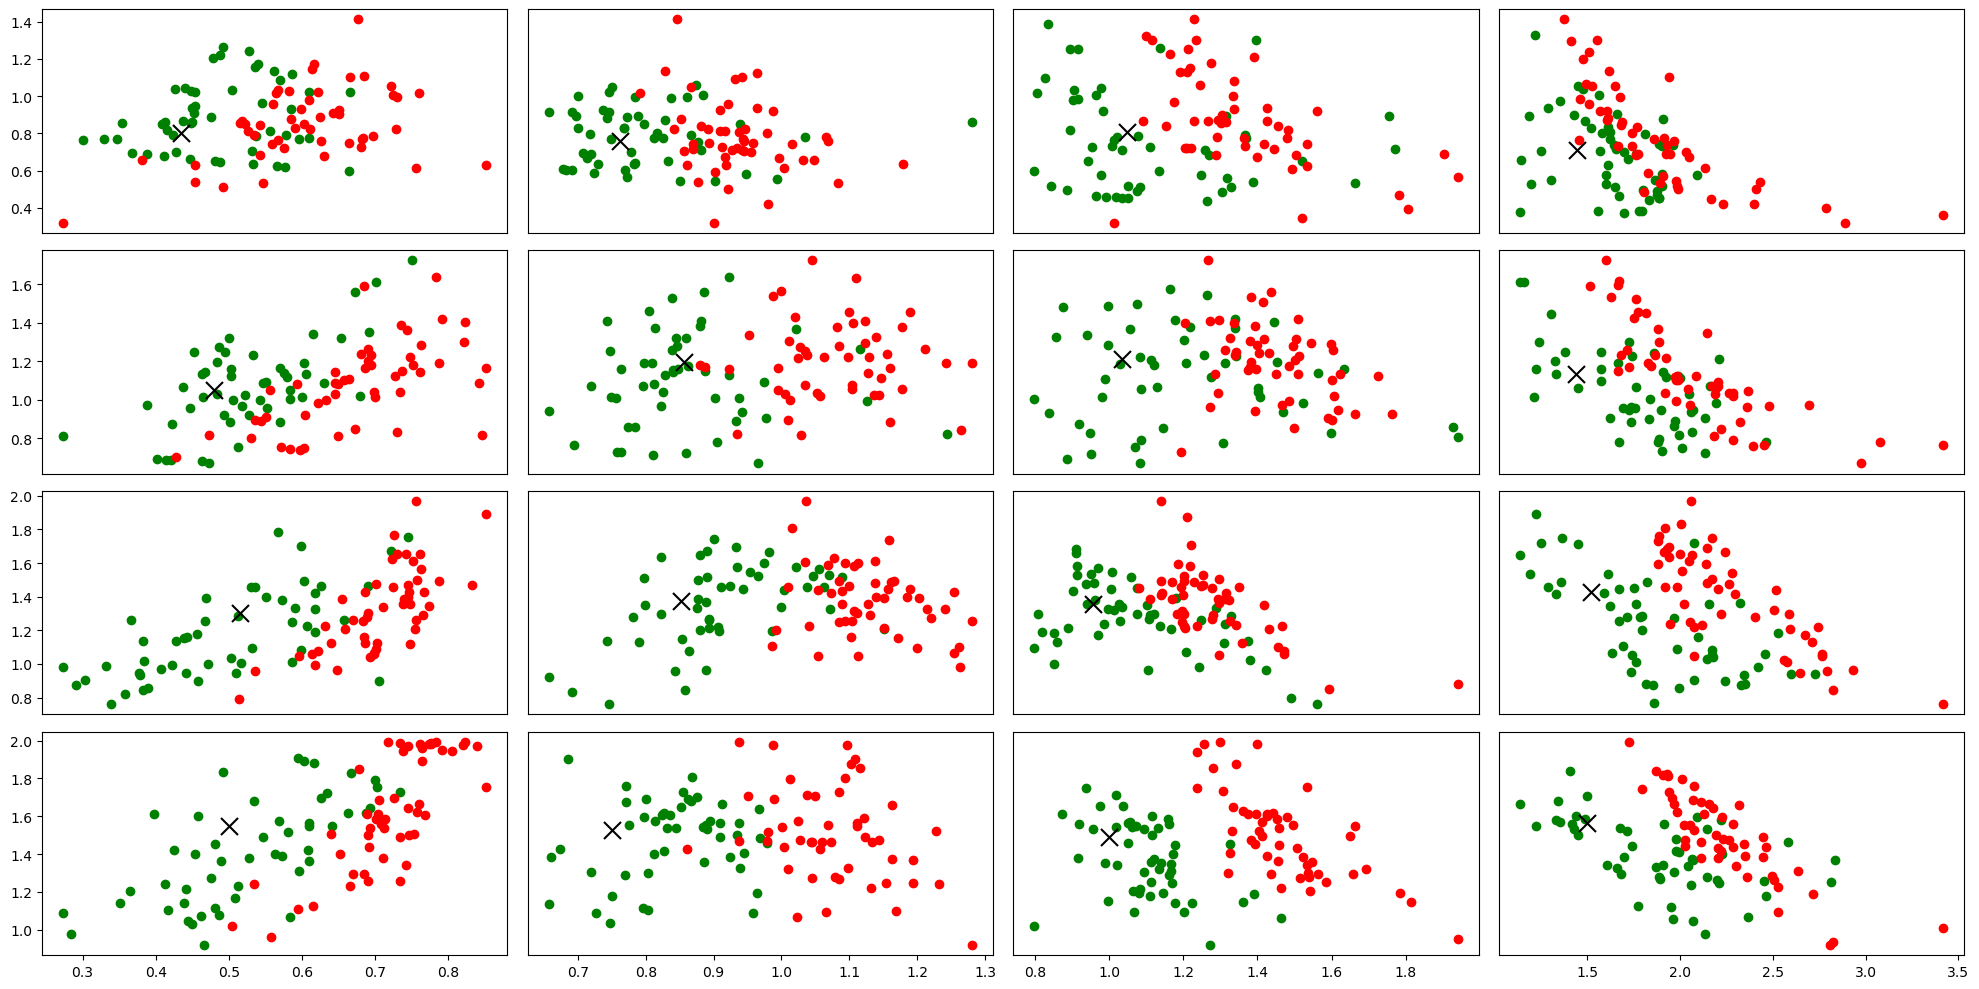

In [12]:
n_comb = 16
fig, axs = plt.subplots(4,4,figsize = (20,10))
axs = axs.ravel()
for i in range(n_comb):
    axs[i].scatter(x = pred_tf[(i*50):((i+1)*50),0], y = pred_tf[(i*50):((i+1)*50),1], color = "green")
    axs[i].scatter(x = ml_data[(i*50):((i+1)*50),0], y = ml_data[(i*50):((i+1)*50),1], color = "red")
    axs[i].scatter(x = param_tf[5+(i*50),0], y = param_tf[5+(i*50),1], color = "black", marker = "x", s = 150)
    if i < 12:
        axs[i].get_xaxis().set_visible(False)
    if (i%4) != 0:
        axs[i].get_yaxis().set_visible(False)  
        
fig.tight_layout()
plt.savefig(plot_path+"metrics_scatter_mle.png", dpi = 300, bbox_inches = "tight")